In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # visualizing data
import seaborn as sns # visualizing data 2
import warnings
warnings.filterwarnings('ignore')

import librosa
import librosa.display

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix


from keras.layers import LSTM, Dropout, Dense, MaxPooling1D, Flatten
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Reshape
from keras.regularizers import l2

In [2]:
#importing all 12,000 data entries to one file for treatment
df = pd.read_csv("dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126108 entries, 0 to 126107
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  126108 non-null  object
 1   age       126108 non-null  int64 
 2   gender    126108 non-null  object
 3   accent    126108 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.8+ MB


In [3]:
df['filename'] = df['filename'].str.replace('D:/AMINA/PFE24/datasets/commonvoice/', '')
df.head(2)

,filename,age,gender,accent
0,cv-valid-train/cv-valid-train/sample-000005.mp3,2,female,us
1,cv-valid-train/cv-valid-train/sample-000008.mp3,7,male,us


In [57]:
# Feature extraction
ds_path = "D:/AMINA/PFE24/datasets/commonvoice/"

def feature_extraction(filename, sampling_rate=16000):
    path = "{}{}".format(ds_path, filename)  # Correct path construction
    features = list()
    audio, _ = librosa.load(path, sr=sampling_rate)
    
    gender = df[df['filename'] == filename].gender.values[0]
    accent = df[df['filename'] == filename].accent.values[0]
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
    features.append(gender)
    features.append(accent)
    features.append(spectral_centroid)
    #this represents the "center of mass" of the spectrum of the audio signal in Hz
    features.append(spectral_bandwidth)
    #This measures the width of the frequency range in which a majority of the signal's energy is contained in HZ
    features.append(spectral_rolloff)
    #This is the frequency below which a certain percentage of the total spectral energy lies in Hz
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate) #16GHz
    #the average of each of the 20 MFCC coefficient over the entire audio signal
    for el in mfcc:
        features.append(np.mean(el))
    
    return features
    
features = feature_extraction(df.iloc[0]['filename'])
print("features: ", features)

features:  ['female', 'us', 1681.5324139796423, 1680.8059344270619, 3543.6304644808743, -552.03424, 72.4191, 26.703245, 36.881405, -12.264315, -4.6388655, -18.739496, 0.186498, -15.599341, -15.913729, -15.611613, -6.366278, -6.7531643, -6.604417, -9.284645, 0.51824677, -8.63934, -10.15817, -2.9375417, -6.451939]


In [58]:
def create_df_features(orig):
    new_rows = []
    tot_rows = len(orig) - 1
    stop_counter = 130000
    
    for idx, row in orig.iterrows():
        if idx >= stop_counter:
            break
        print("\r", end="")
        print("{}/{}".format(idx, tot_rows), end="", flush=True)
        features = feature_extraction(row['filename'])
        features.append(row['age'])
        new_rows.append(features)
    
    # Define column names for the features DataFrame
    column_names = ["gender", "accent", "spectral_centroid", "spectral_bandwidth", "spectral_rolloff",
                    "mfcc1", "mfcc2", "mfcc3", "mfcc4", "mfcc5", "mfcc6", "mfcc7", "mfcc8",
                    "mfcc9", "mfcc10", "mfcc11", "mfcc12", "mfcc13", "mfcc14", "mfcc15", "mfcc16",
                    "mfcc17", "mfcc18", "mfcc19", "mfcc20", "age"]
    
    return pd.DataFrame(new_rows, columns=column_names)

# Uncomment the line below if running for the first time
#df_features = create_df_features(df)

0/126107

126107/126107

In [5]:
#df_features.to_csv('df_features.csv', index=False) # to save to disk
df_features = pd.read_csv('df_features.csv')
df_features.head(2)

,gender,accent,spectral_centroid,spectral_bandwidth,spectral_rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,age
0,female,us,1681.532414,1680.805934,3543.630464,-552.03424,72.41910,26.703245,36.881405,-12.264315,...,-6.366278,-6.753164,-6.604417,-9.284645,0.518247,-8.639340,-10.15817,-2.937542,-6.451939,2
1,male,us,2020.193755,1424.773656,3422.301136,-390.63916,86.60778,-31.042065,17.366293,1.816059,...,-2.807799,-12.215798,-7.395828,-7.008618,1.758026,-2.460396,-3.82122,-5.165414,-5.350076,7


In [8]:
#THE MODEL
categorical_cols = ['gender', 'accent']
numerical_cols = [col for col in df_features.columns if col not in ['age', 'gender', 'accent']]

# One-hot encoding the categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'#numerical data passes unchanged
)

#Encoding the 'age' column using LabelEncoder() to convert the age categories into numerical labels.
X_preprocessed = preprocessor.fit_transform(df_features.drop(columns=['age']))
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_features['age'])


#Split data into 3 sets (train, val, test) using StratifiedKFold to ensure equal representation of age groups in all sets
#split into train set (60%)  + temp test set split into (20% test +  20% val)
X_train, X_temp, y_train, y_temp = train_test_split(X_preprocessed, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Convert input features to float32
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# Standardize input features to have a mean of 0 and a standard deviation of 1.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Model Structure
#2 LSTM layers + 
model = Sequential([
    LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(units=128, return_sequences=True),
    LSTM(units=128),
    Dropout(0.3), # to prevent overfitting, 30% of the input units will be randomly dropped during training
    Flatten(), #to flatten the input into a one-dimensional array
    Dense(units=32, activation='relu'),
    BatchNormalization(), #prevent overfitting
    Dense(units=len(label_encoder.classes_), activation='softmax')
])
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
#batch_size for GPU: 1, 2, 4, 8, 16, 32, 64, 128, 256, 512
history = model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, 
                    epochs=10, batch_size=16, validation_data=(X_val.reshape((X_val.shape[0], X_val.shape[1], 1)), y_val))

# Preprocess test data (so it's on the same scale as the train + val data)
X_test = scaler.transform(X_test)

# Predict on test data
#"y_test_decoded " is the real age class and "y_pred_decoded " the one predicted by the mode
y_pred_probabilities = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode labels
#These line decodes the encoded labels of the test data back to their original form
y_test_decoded = label_encoder.inverse_transform(y_test)
#converts these numerical indices back to their corresponding age categories.
y_pred_decoded = label_encoder.inverse_transform(y_pred)


# Calculate evaluation metrics
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
precision = precision_score(y_test_decoded, y_pred_decoded, average='weighted', labels=np.unique(y_pred_decoded))
recall = recall_score(y_test_decoded, y_pred_decoded, average='weighted', labels=np.unique(y_pred_decoded))
f1 = f1_score(y_test_decoded, y_pred_decoded, average='weighted', labels=np.unique(y_pred_decoded))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=np.unique(y_pred_decoded))

Epoch 1/10
6306/6306 [==============================] - 606s 95ms/step - loss: 1.6659 - accuracy: 0.3305 - val_loss: 1.4819 - val_accuracy: 0.4160
Epoch 2/10
6306/6306 [==============================] - 590s 94ms/step - loss: 1.2973 - accuracy: 0.5130 - val_loss: 1.0447 - val_accuracy: 0.6264
Epoch 3/10
6306/6306 [==============================] - 594s 94ms/step - loss: 0.9290 - accuracy: 0.6782 - val_loss: 0.7687 - val_accuracy: 0.7304
Epoch 4/10
6306/6306 [==============================] - 594s 94ms/step - loss: 0.7184 - accuracy: 0.7583 - val_loss: 0.6314 - val_accuracy: 0.7848
Epoch 5/10
6306/6306 [==============================] - 727s 115ms/step - loss: 0.5902 - accuracy: 0.8041 - val_loss: 0.5656 - val_accuracy: 0.8055
Epoch 6/10
6306/6306 [==============================] - 761s 121ms/step - loss: 0.4980 - accuracy: 0.8357 - val_loss: 0.5126 - val_accuracy: 0.8255
Epoch 7/10
6306/6306 [==============================] - 736s 117ms/step - loss: 0.4335 - accuracy: 0.8571 - val_loss

In [9]:
print("Number of rows in training set:", X_train.shape[0])
print("Number of rows in validation set:", X_val.shape[0])
print("Number of rows in testing set:", X_test.shape[0])

Number of rows in training set: 100886
Number of rows in validation set: 18916
Number of rows in testing set: 6306


In [10]:
#Performance
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8631462099587695
Precision: 0.8636097893371728
Recall: 0.8631462099587695
F1 Score: 0.8629190224382428


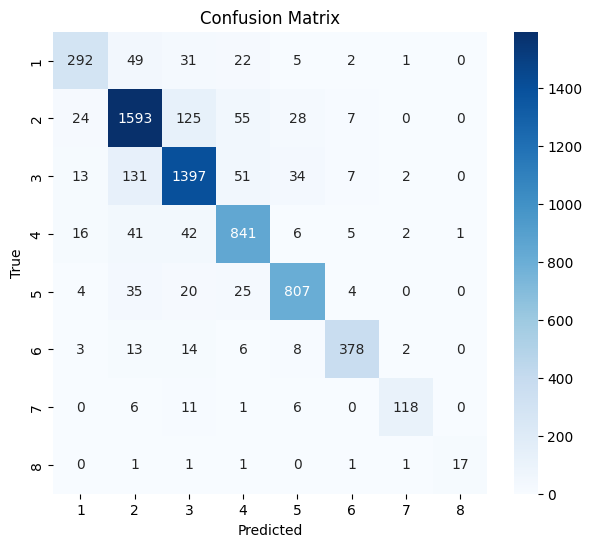

In [11]:
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [12]:
model.save('my_model.h5')